## t-SNE

In [1]:
import numpy as np

def neg_distance(X):
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return -D

def softmax(X):
    e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))
    np.fill_diagonal(e_x, 0.)
    e_x = e_x + 1e-8
    return e_x / e_x.sum(axis=1).reshape([-1, 1])

def calc_prob_matrix(distances, sigmas=None):
    if sigmas is not None:
        two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
        return softmax(distances / two_sig_sq)
    else:
        return softmax(distances)

def _perplexity(prob_matrix):
    entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
    perplexity = 2 ** entropy
    return perplexity

def perplexity(distances, sigmas):
    return _perplexity(calc_prob_matrix(distances, sigmas))

def binary_search(fn, target, tol=1e-10, max_iter=10000,
                  lower=1e-20, upper=1000.):
    for i in range(max_iter):
        guess = (lower + upper) / 2.
        val = fn(guess)
        if val > target:
            upper = guess
        else:
            lower = guess
        if np.abs(val - target) <= tol:
            break
    return guess

def find_optimal_sigmas(distances, target_perplexity):
    sigmas = []
    for i in range(distances.shape[0]):
        fn = lambda sigma: \
            perplexity(distances[i:i+1, :], np.array(sigma))
        correct_sigma = binary_search(fn, target_perplexity)
        sigmas.append(correct_sigma)
    return np.array(sigmas)

def p_conditional_to_joint(P):
    return (P + P.T) / (2. * P.shape[0])

def q_joint(Y):
    inv_distances = neg_squared_euc_dists(Y)
    distances = np.power(1., -inv_distances,-1)
    np.fill_diagonal(distances, 0.)
    return distances / np.sum(distances), distances

def p_joint(X, target_perplexity):
    distances = neg_distance(X)
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    p_conditional = calc_prob_matrix(distances, sigmas)
    P = p_conditional_to_joint(p_conditional)
    return P

def tsne_grad(P, Q, Y, distances):
    pq_diff = P - Q
    pq_expanded = np.expand_dims(pq_diff, 2)
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    distances_expanded = np.expand_dims(distances, 2)
    y_diffs_wt = y_diffs * distances_expanded
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
    return grad

def t_SNE(X, num_component, num_iters = 500, learning_rate = 10., momentum = .9):
    Y = np.random.normal(0., 0.0001,[X.shape[0], num_component])
    P = p_joint(X, 20)
    if momentum:
        Y_m2 = Y
        Y_m1 = Y
    for i in range(num_iters):
        Q, distances = q_joint(Y)
        grads = tsne_grad(P, Q, Y, distances)
        Y = Y - learning_rate * grads
        if momentum:
            Y += momentum * (Y_m1 - Y_m2)
            Y_m2 = Y_m1
            Y_m1 = Y
    return Y

#### Library

In [29]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits 
import pandas as pd


In [30]:
data = load_digits()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


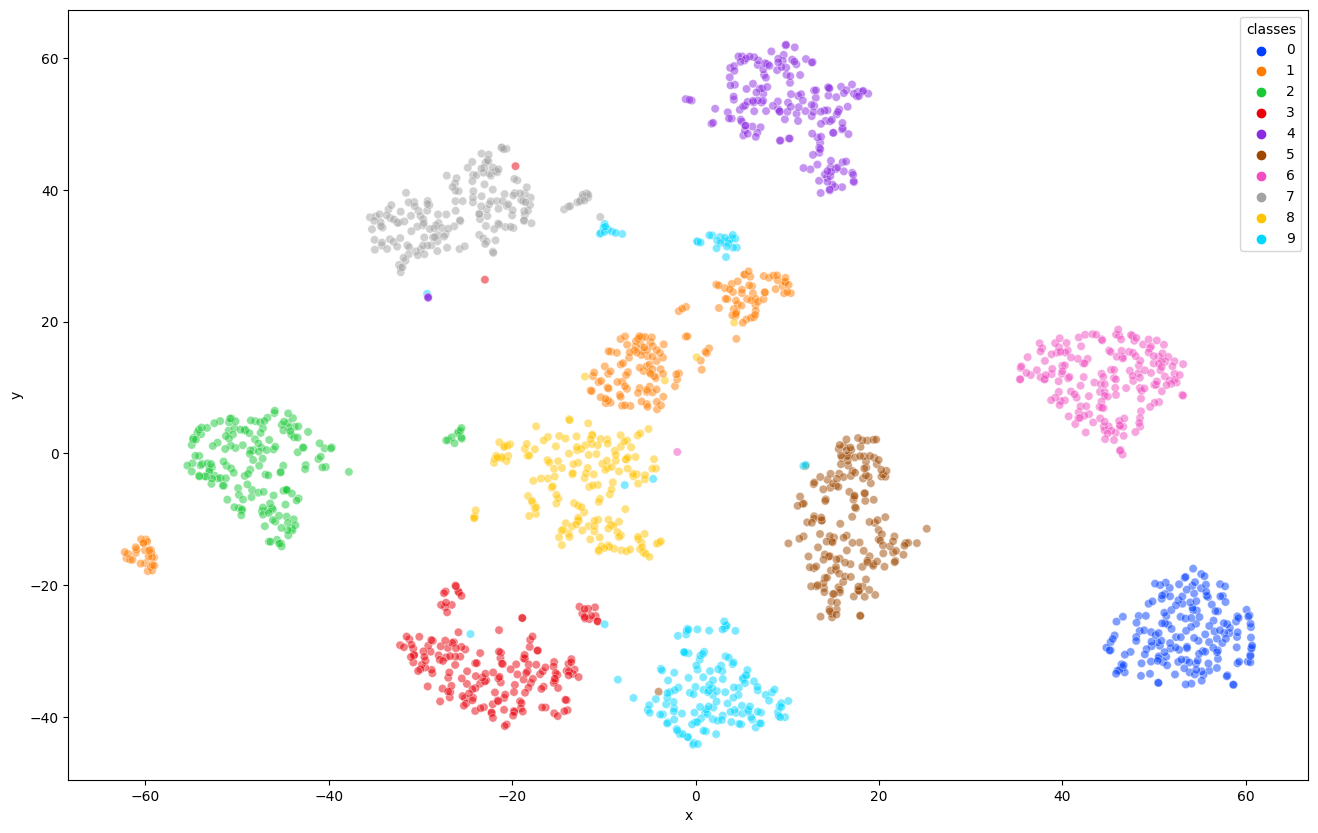

In [35]:
tsne2 = TSNE(n_components=2).fit_transform(data.data)

tsne_df2 = pd.DataFrame({'x': tsne2[:, 0], 'y':tsne2[:, 1], 'classes':data.target})

palette = sns.color_palette("bright", 10)
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x = 'x', y = 'y',
    hue = 'classes',
    data = tsne_df2,
    legend = "full",
    alpha = 0.5,
    palette = palette
)

plt.show()


###### reference
###### https://woosikyang.github.io/first-post.html